## overview
- pipeline that finds the best suggestion, prototype

In [35]:
## import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import statistics
from datetime import datetime
from sklearn.model_selection import train_test_split
import random, sys, copy, os, json

In [36]:
# Set seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

# Ensure deterministic algorithms
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

Data

In [37]:
# df = pd.read_csv("data/filtered_model_data.csv")

In [38]:
# df["start_time"] = df["start_time"].astype('datetime64[ns]')
# df = df.sort_values(by=["patient_id", "start_time"])

Create training data

In [39]:
# given a row of sessions, take domain_ids and domain_scores, which are in string format separated by ",", and replace with a list of the values
def process_row(row):
    values_a = [int(x.strip()) for x in str(row['domain_ids']).split(',')]
    values_b = [float(x.strip()) for x in str(row['domain_scores']).split(',')]
    return values_a, values_b

In [40]:
# take in a dataframe of a patient's session, extract information useful for training
def create_training_data(data: pd.DataFrame):
    # Initialize variables
    session_row = [] # contents of a row (patient id, encoding, cur score, prev score, repeat)
    overall = [] # aggregate of everything (n sessions x 44)

    cur_score = np.zeros((14)) # score for each session
    # cur_score.fill(np.nan)
    prev_score = None

    seen = {} # dictionary for seen
    patient_id = data["patient_id"].iloc[0] # save patient_id

    # Sort data by session start time
    data = data.sort_values(by=["start_time"])

    # Process each row
    for idx, row in data.iterrows():
        domains, domain_scores = process_row(row)  # returns a list of domains : int and of domain_scores : float

        # Track repeat status and update scores
        repeat = False

        for j, domain in enumerate(domains):
            if domain not in seen:
                seen[domain] = True
            else:
                repeat = True
            
            cur_score[domain - 1] = domain_scores[j] # update score in the loop

        # Encode domains for this session
        domain_encoding = np.zeros(14)
        for domain in domains:
            domain_encoding[domain - 1] = 1
        
        

        # if the session does not contain the target domain or is the first (no prev score), continue in the loop without doing anything, do this before appending
        if prev_score is None:
            session_row = []
            prev_score = cur_score.copy()
            continue
        # assert np.sum(domain_encoding) != 1, "continue not working"

        # append everything in the row list
        session_row.append(patient_id)
        session_row.extend(domain_encoding.copy().tolist())
        session_row.extend(prev_score.copy().tolist())
        session_row.extend(cur_score.copy().tolist())
        session_row.append(repeat)
        assert len(session_row) == 44, "session row length weird"

        # append row to overall, reset
        overall.append(session_row)
        session_row = []
        prev_score = cur_score.copy()

    # Convert to numpy arrays
    if overall:
        overall = np.array(overall)
        assert len(overall.shape) == 2, "dimensions of overall wrong"
    else:
        # Handle case where scores is empty
        return pd.DataFrame(columns=["patient_id"] + ["domain %d encoding" % i for i in range(1, 15)] +
                                   ["domain %d score" % i for i in range(1, 15)] +
                                   ["domain %d target" % i for i in range(1, 15)] +
                                   ["repeat"])
    
        # Create column names
    column_names = (
        ["patient_id"]
        + [f"domain {i} encoding" for i in range(1, 15)]
        + [f"domain {i} score" for i in range(1, 15)]
        + [f"domain {i} target" for i in range(1, 15)]
        + ["repeat"]
    )

    # Create dataframe
    scores_df = pd.DataFrame(overall, columns=column_names)
    scores_df.reset_index(drop=True, inplace=True)
    return scores_df

In [41]:
# data = df.groupby("patient_id")[df.columns].apply(create_training_data).reset_index(drop=True)

In [42]:
data = pd.read_csv("data/next_step_data_0.csv")

In [43]:
data

,patient_id,domain 1 encoding,domain 2 encoding,domain 3 encoding,domain 4 encoding,domain 5 encoding,domain 6 encoding,domain 7 encoding,domain 8 encoding,domain 9 encoding,...,domain 6 target,domain 7 target,domain 8 target,domain 9 target,domain 10 target,domain 11 target,domain 12 target,domain 13 target,domain 14 target,repeat
0,2171.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.000,0.00,0.000,0.000,0.000,0.0,0.000,0.000,0.0,0.0
1,2171.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,...,0.326,0.21,0.000,0.000,0.000,0.0,0.000,0.000,0.0,0.0
2,2171.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.326,0.21,0.000,0.630,0.000,0.0,0.000,0.000,0.0,0.0
3,2171.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.326,0.21,0.000,0.630,0.000,0.0,0.000,0.000,0.0,1.0
4,2171.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.326,0.21,0.000,0.630,0.000,0.0,0.000,0.000,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5835360,568669.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.480,1.00,0.882,0.667,0.846,1.0,0.188,0.827,0.0,1.0
5835361,568669.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.480,1.00,0.882,0.667,0.846,1.0,0.188,0.827,0.0,1.0
5835362,568669.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.480,1.00,0.882,0.667,0.846,1.0,0.188,0.827,0.0,1.0
5835363,568669.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.480,1.00,0.882,0.667,0.846,1.0,0.218,0.827,0.0,1.0


In [44]:
train_data, test_data = train_test_split(data, test_size=0.25, random_state=42)
n_samples = 100000

## one sample for train, only to see if it learns that one example
train_data = train_data[:n_samples].copy()
test_data = test_data[:n_samples].copy()

In [45]:
score_columns = ["domain %d score" %i for i in range(1, 15)]
encoding_columns = ["domain %d encoding" %i for i in range(1, 15)]
target_columns = ["domain %d target" %i for i in range(1, 15)]
repeat_columns = ["repeat"]

In [46]:
# create missing indicator when given the score data
def create_missing_indicator(data):
    (l, w) = data.shape
    temp = np.zeros((l, w*2))
    for i in range(l):
        for d in range(w):
            p = data[i, d]
            # update output array
            if p == 0:
            # if np.isnan(p):
                missing_ind = np.random.choice(2, 1)[0]
                temp[i, d*2] = missing_ind
                temp[i, d*2+1] = missing_ind
            else:
                temp[i, d*2] = p # score
                temp[i, d*2+1] = 1-p # 1-score
    return copy.deepcopy(temp)

In [47]:
# given a processed dataframe, return data and target tensors that can be put in the model
def create_model_data(data : pd.DataFrame):
    target = data[target_columns].copy().to_numpy() * data[encoding_columns].copy().to_numpy()
    data_scores = create_missing_indicator(data[score_columns].copy().to_numpy())
    # final_data = np.hstack((data[encoding_columns].copy().to_numpy(), data_scores)) ## with no encoding columns because we have other
    return data_scores, target

In [48]:
x_test, y_test = create_model_data(test_data)

Model

In [49]:
## input : 14 domain encodings + 14 domains (28 total features with missing indicator)
## output: 28 score (prediction for the scores after next domain)
class NN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        n_domains = 14
        
        self.model = torch.nn.Sequential(
            torch.nn.Linear(n_domains * 3, 100),
            torch.nn.Sigmoid(),
            torch.nn.Linear(100, n_domains)
        )

    def forward(self, x):
        return self.model(x)

# used for batch training
class customDataset(Dataset):
    def __init__(self, data, target):
        super().__init__()
        self.data = data
        self.target = target

    def __len__(self):
        return self.data.shape[0]

    def __getitem__(self, index):
        return self.data[index, :], self.target[index, :]

In [50]:
model = NN()
model = torch.load("output/experiment4/model.pt", map_location=torch.device('cpu'))

In [51]:
def add_encoding(scores : np.ndarray, encoding : np.ndarray):
    return torch.from_numpy(np.hstack((encoding, scores))).float()

In [52]:
# return predictions, loss, and mae
def predict(model, x, y):
    loss_function = torch.nn.MSELoss()
    with torch.no_grad():
        predictions = model(x)
        loss = loss_function(predictions, y.reshape(predictions.shape))    
        return predictions.clone().numpy(), loss.clone().item(), torch.mean(torch.abs(predictions - y.reshape(predictions.shape))).clone().item()

In [53]:
# plot average improvement plots and store, d_type= Ground Truth or Prediction, mode=train or test, cur_score=whatever we need, data=test or train data
def plot_average_improvements(mode, cur_score, encoding, prev_score):
    # Step 1: Compute differences
    differences = cur_score - prev_score
    # Step 2: Mask the differences using the encoding array
    masked_differences = np.where(encoding == 1, differences, 0)  # Retain differences only where encoding is 1
    # Step 3: Compute the column-wise sum and count
    column_sums = np.sum(masked_differences, axis=0)  # Sum of differences for each column
    column_counts = np.sum(encoding, axis=0)          # Number of 1s in each column
    # Step 4: Filter out columns with no encoding == 1
    valid_columns = column_counts > 0  # Boolean mask for valid columns
    filtered_sums = column_sums[valid_columns]
    filtered_counts = column_counts[valid_columns]
    # Step 5: Compute the column-wise averages for valid columns
    filtered_averages = filtered_sums / filtered_counts
    filtered_column_indices = np.where(valid_columns)[0]
    # Plot the bar chart
    fig, ax = plt.subplots(figsize=(8, 6))  # Create the figure and axes
    bars = ax.bar(range(len(filtered_averages)), filtered_averages, tick_label=[f"{i+1}" for i in filtered_column_indices])
    # Add values to the bars
    ax.bar_label(bars, fmt='%.4f', label_type='edge')
    # Set the y-axis range
    ax.set_ylim(-0.1, 0.5)
    # Add labels and title
    title_s = "%s Data Domain Improvement Averages" % (mode)
    plt.xlabel("Domains", fontsize=12)
    plt.ylabel("Average Difference", fontsize=12)
    plt.title(title_s, fontsize=16)
    plt.tight_layout()
    plt.show()

In [54]:
def overall_avg_improvement(cur_score, prev_score, encoding):
    differences = cur_score - prev_score
    count = np.sum(encoding)
    total_improvement = np.sum(differences) / count
    return total_improvement

Calculate Ground Truth

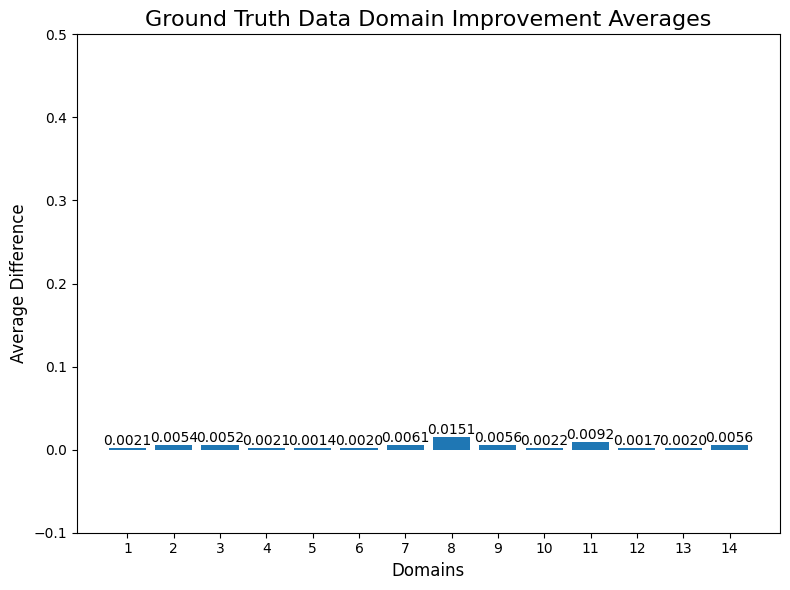

In [55]:
plot_average_improvements("Ground Truth", test_data[target_columns].to_numpy(), test_data[encoding_columns].to_numpy(), test_data[score_columns].to_numpy())

In [56]:
overall_avg_improvement(test_data[target_columns].to_numpy(), test_data[score_columns].to_numpy(), test_data[encoding_columns].to_numpy())

0.003231024135871701

Predict Random

In [57]:
# Get matrix dimensions
rows, cols = y_test.shape  # Example: (100000, 14)

# Create a zero matrix
random_encoding = np.zeros((rows, cols), dtype=int)

# Generate a random column index for each row
col_indices = np.random.randint(0, cols, size=rows)  # Shape (100000,)

# Assign 1s at the randomly selected column indices
random_encoding[np.arange(rows), col_indices] = 1

In [58]:
np.isnan(random_encoding).any()

False

In [59]:
x_test_random = add_encoding(x_test, random_encoding)

In [60]:
random_predictions, random_loss, random_mae = predict(model, x_test_random, torch.from_numpy(y_test).float())

In [61]:
overall_avg_improvement(random_predictions, test_data[score_columns].to_numpy(), random_encoding)

-5.9749321419318075

Predict Best

In [63]:
def create_single_encoding(rows, cols, column_index):
    if column_index < 0 or column_index >= cols:
        raise ValueError("Column index is out of bounds.")

    # Create a zero matrix
    matrix = np.zeros((rows, cols), dtype=int)

    # Set all values in the specified column to 1
    matrix[:, column_index] = 1

    return matrix

In [64]:
prediction_list = []
rows, cols = y_test.shape

In [65]:
for domain in range(14):
    encoding = create_single_encoding(rows, cols, domain)
    x_test_single = add_encoding(x_test, encoding)
    single_prediction, loss, mae = predict(model, x_test_single, torch.from_numpy(y_test).float())
    prediction_list.append(single_prediction[:, domain])

In [66]:
prediction_matrix = np.column_stack(prediction_list)  # Shape: (100000, 14)

# Find the index of the max value for each row
max_indices = np.argmax(prediction_matrix, axis=1)  # Shape: (100000,)

In [67]:
# Step 1: Create a zero matrix of shape (100000, 14)
best_encoding = np.zeros((rows, cols), dtype=int)

# Step 2: Assign 1s at the max_indices positions
best_encoding[np.arange(rows), max_indices] = 1

In [68]:
best_predicitons = np.zeros((rows, cols), dtype=prediction_matrix.dtype)  # Keep same data type

# Step 2: Fill in the max values at their corresponding positions
best_predicitons[np.arange(rows), max_indices] = prediction_matrix[np.arange(rows), max_indices]

In [69]:
overall_avg_improvement(best_predicitons, test_data[score_columns].to_numpy(), best_encoding)

-5.649083096993542

Bad pipe message: %s [b'\x1d']
Bad pipe message: %s [b"&pGc\x8c\xaf\x86\x1ei\x83\x06'o\xf8y\x00\x01|\x00\x00\x00\x01\x00\x02\x00\x03\x00\x04\x00\x05\x00\x06\x00\x07\x00\x08\x00\t\x00\n\x00\x0b\x00\x0c\x00\r\x00\x0e\x00\x0f\x00\x10\x00\x11\x00\x12\x00\x13\x00\x14\x00\x15\x00\x16\x00\x17\x00\x18\x00\x19\x00\x1a\x00\x1b\x00/\x000\x001\x002\x003\x004\x005\x006\x007\x008\x009\x00:\x00;\x00<\x00=\x00>\x00?\x00@\x00A\x00B\x00C\x00D\x00E\x00F\x00g\x00h\x00i\x00j\x00k\x00l\x00m\x00\x84\x00\x85\x00\x86\x00\x87\x00\x88\x00\x89\x00\x96\x00\x97\x00\x98\x00\x99\x00\x9a\x00\x9b\x00\x9c\x00\x9d\x00\x9e\x00\x9f\x00\xa0\x00\xa1\x00\xa2\x00\xa3\x00\xa4\x00\xa5\x00\xa6\x00\xa7\x00\xba\x00\xbb\x00\xbc\x00\xbd\x00\xbe\x00\xbf\x00\xc0\x00\xc1\x00\xc2\x00\xc3\x00\xc4\x00\xc5\x13\x01\x13\x02\x13\x03\x13\x04\x13\x05\xc0\x01\xc0\x02\xc0\x03\xc0\x04\xc0\x05\xc0\x06\xc0\x07\xc0\x08\xc0\t\xc0\n\xc0\x0b\xc0\x0c\xc0\r\xc0\x0e\xc0\x0f"]
Bad pipe message: %s [b'^3a\xd7\x07\x18\xd5\xab\xf7\xf2\x05\xb1\x04\n\xbc\xa0\x14'